# URL Classification Neural Network

### Imports and Getting Data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

I used the dataset_small because it has a similar number of phishing vs non-phishing URLs

In [2]:
URL_data = pd.read_csv(
    'https://github.com/GregaVrbancic/Phishing-Dataset/raw/master/dataset_small.csv',
    sep=',', encoding='latin-1')

# get rid of the unnecessary domain special characters features
data = URL_data.drop(["qty_slash_domain","qty_questionmark_domain","qty_equal_domain","qty_and_domain","qty_exclamation_domain","qty_space_domain","qty_tilde_domain","qty_comma_domain","qty_plus_domain","qty_asterisk_domain","qty_hashtag_domain","qty_dollar_domain","qty_percent_domain"], axis=1)

display(data)
print(data.shape)

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_questionmark_url,qty_equal_url,qty_at_url,qty_and_url,qty_exclamation_url,qty_space_url,...,qty_ip_resolved,qty_nameservers,qty_mx_servers,ttl_hostname,tls_ssl_certificate,qty_redirects,url_google_index,domain_google_index,url_shortened,phishing
0,2,0,0,0,0,0,0,0,0,0,...,1,4,2,3598,0,0,0,0,0,0
1,4,0,0,2,0,0,0,0,0,0,...,1,4,1,3977,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,1,2,1,10788,0,0,0,0,0,0
3,2,0,0,3,0,0,0,0,0,0,...,1,2,1,14339,1,0,0,0,0,1
4,1,1,0,4,0,0,0,0,0,0,...,1,2,1,389,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,1,0,0,5,0,1,0,0,0,0,...,1,2,2,563,0,0,0,0,0,1
58641,2,0,0,0,0,0,0,0,0,0,...,1,4,0,122,1,0,0,0,0,0
58642,5,6,3,6,0,2,1,1,0,0,...,1,2,1,1122,0,0,0,0,0,1
58643,2,0,0,0,0,0,0,0,0,0,...,5,2,5,299,1,1,0,0,0,0


(58645, 99)


### Simple Feature Engineering

In [3]:
# target and show only correlations with phishing
URL_corr = data.corr()[['phishing']]

# create a table of features and their correlation values beyond +-0.25
corr_positive_filtered = URL_corr[URL_corr['phishing'] > 0.1]
corr_negative_filtered = URL_corr[URL_corr['phishing'] < -0.1]

corr_filtered = pd.concat([corr_positive_filtered, corr_negative_filtered])

display(corr_filtered.head())


,phishing
qty_dot_url,0.140542
qty_hyphen_url,0.140790
qty_underline_url,0.150771
qty_slash_url,0.598533
qty_equal_url,0.216086


In [4]:
# list of features with those target correlation values
features = list(corr_filtered.index)

print(features)
print(len(features))

['qty_dot_url', 'qty_hyphen_url', 'qty_underline_url', 'qty_slash_url', 'qty_equal_url', 'qty_and_url', 'qty_tld_url', 'length_url', 'qty_hyphen_domain', 'qty_vowels_domain', 'qty_dot_directory', 'qty_hyphen_directory', 'qty_underline_directory', 'qty_slash_directory', 'qty_questionmark_directory', 'qty_equal_directory', 'qty_at_directory', 'qty_and_directory', 'qty_exclamation_directory', 'qty_space_directory', 'qty_tilde_directory', 'qty_comma_directory', 'qty_plus_directory', 'qty_asterisk_directory', 'qty_hashtag_directory', 'qty_dollar_directory', 'qty_percent_directory', 'directory_length', 'qty_dot_file', 'qty_hyphen_file', 'qty_underline_file', 'qty_slash_file', 'qty_questionmark_file', 'qty_equal_file', 'qty_at_file', 'qty_and_file', 'qty_exclamation_file', 'qty_space_file', 'qty_tilde_file', 'qty_comma_file', 'qty_plus_file', 'qty_asterisk_file', 'qty_hashtag_file', 'qty_dollar_file', 'qty_percent_file', 'file_length', 'qty_dot_params', 'qty_hyphen_params', 'qty_underline_par

<Axes: >

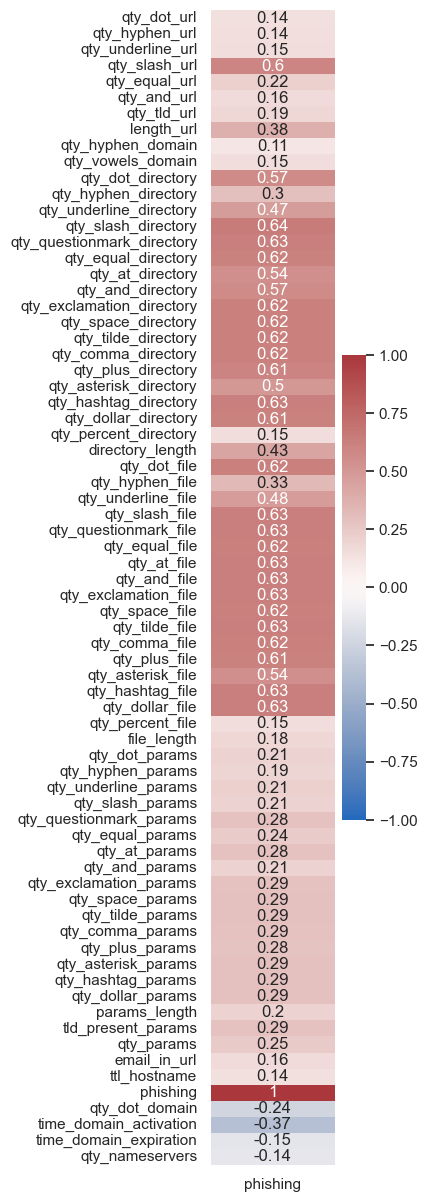

In [5]:
# showing the correlation values for those target features
sns.set(rc={'figure.figsize':(2,15)})
sns.heatmap(corr_filtered, vmin=-1, cmap="vlag", annot=True)

### Preparing Data

In [6]:
# keep only the intended features
data = data[features]

display(data.head())

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_equal_url,qty_and_url,qty_tld_url,length_url,qty_hyphen_domain,qty_vowels_domain,...,params_length,tld_present_params,qty_params,email_in_url,ttl_hostname,phishing,qty_dot_domain,time_domain_activation,time_domain_expiration,qty_nameservers
0,2,0,0,0,0,0,1,14,0,3,...,-1,-1,-1,0,3598,0,2,4927,185,4
1,4,0,0,2,0,0,1,38,0,10,...,-1,-1,-1,0,3977,0,4,8217,-1,4
2,1,0,0,1,0,0,1,24,0,7,...,-1,-1,-1,0,10788,0,1,258,106,2
3,2,0,0,3,0,0,1,38,0,7,...,-1,-1,-1,0,14339,1,2,2602,319,2
4,1,1,0,4,0,0,1,46,1,7,...,-1,-1,-1,0,389,1,1,-1,-1,2


In [7]:
# randomize the rows, just for good practice

data = data.sample(frac=1, random_state=0).reset_index(drop=True)

# split the data into the features and label

X = data.drop("phishing", axis=1)
# X = X.replace(-1, 0)
Y = data["phishing"]

display(X.head())
print(Y.head())

,qty_dot_url,qty_hyphen_url,qty_underline_url,qty_slash_url,qty_equal_url,qty_and_url,qty_tld_url,length_url,qty_hyphen_domain,qty_vowels_domain,...,qty_dollar_params,params_length,tld_present_params,qty_params,email_in_url,ttl_hostname,qty_dot_domain,time_domain_activation,time_domain_expiration,qty_nameservers
0,2,5,0,5,0,0,1,68,0,8,...,-1,-1,-1,-1,0,225,2,-1,-1,4
1,1,1,0,2,0,0,1,24,1,6,...,-1,-1,-1,-1,0,5864,1,119,245,2
2,1,0,0,1,0,0,1,13,0,1,...,-1,-1,-1,-1,0,292,1,517,212,2
3,2,0,0,4,0,0,1,60,0,3,...,-1,-1,-1,-1,0,14170,2,1420,40,2
4,2,0,0,3,0,0,1,45,0,6,...,-1,-1,-1,-1,0,138,2,-1,-1,4


0    0
1    1
2    1
3    1
4    1
Name: phishing, dtype: int64


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

np.random.seed(0)

# standardize data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

### Training the model

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# single run neural network model
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', metrics.AUC()])

# Train the model
model.fit(X_train, Y_train, epochs=40, batch_size=32, validation_split=0.2)

Epoch 1/40
1173/1173 [==============================] - 1s 757us/step - loss: 0.2519 - accuracy: 0.8948 - auc: 0.9615 - val_loss: 0.2304 - val_accuracy: 0.9015 - val_auc: 0.9718
Epoch 2/40
1173/1173 [==============================] - 1s 668us/step - loss: 0.2123 - accuracy: 0.9135 - auc: 0.9724 - val_loss: 0.2037 - val_accuracy: 0.9160 - val_auc: 0.9747
Epoch 3/40
1173/1173 [==============================] - 1s 671us/step - loss: 0.2014 - accuracy: 0.9173 - auc: 0.9751 - val_loss: 0.1924 - val_accuracy: 0.9222 - val_auc: 0.9777
Epoch 4/40
1173/1173 [==============================] - 1s 669us/step - loss: 0.1923 - accuracy: 0.9218 - auc: 0.9773 - val_loss: 0.1898 - val_accuracy: 0.9265 - val_auc: 0.9785
Epoch 5/40
1173/1173 [==============================] - 1s 672us/step - loss: 0.1868 - accuracy: 0.9240 - auc: 0.9785 - val_loss: 0.1833 - val_accuracy: 0.9264 - val_auc: 0.9800
Epoch 6/40
1173/1173 [==============================] - 1s 672us/step - loss: 0.1831 - accuracy: 0.9271 - auc:

In [10]:
loss, accuracy, auc = model.evaluate(X_test, Y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test AUC:", auc)

367/367 [==============================] - 0s 439us/step - loss: 0.1947 - accuracy: 0.9365 - auc: 0.9786
Test Loss: 0.1947379857301712
Test Accuracy: 0.9364822506904602
Test AUC: 0.9785700440406799
